## Imports

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

In [1]:
# imports for fr and model
import sys
import pandas as pd
from PIL import Image
from fr_utils import *
from inception_blocks import *
from matplotlib.pyplot import figure

%matplotlib inline

from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

# imports for LIME
import sklearn
import sklearn.datasets
import sklearn.ensemble

import lime
import lime.lime_tabular
from lime import lime_image
from __future__ import print_function

C:\Users\tyler.TRN\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Setup Model and load Database

In [9]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [10]:
# given image, returns encoding
def img_to_encoding(img1, model):
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding


# given image path, returns encoding
def img_path_to_encoding(image_path, model):
    return img_to_encoding(cv2.imread(image_path, 1), model)

In [12]:
# specify model input, compile, then load the weights
FRmodel= faceRecoModel(input_shape=(3, 96, 96))
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [13]:
# given path to images, fill the database with them
def fillDatabase(databasePath, database):
    databasePath = os.fsencode(databasePath)
    if not os.path.exists(databasePath):
        sys.exit('Invalid database path')
        
    for img in os.listdir(databasePath):
        img_path = os.path.join(databasePath, os.fsencode(img))
        database[img.decode('UTF-8')] = img_path_to_encoding(os.fsdecode(img_path), FRmodel)

In [14]:
database = {}
fillDatabase('images', database)

## Create LIME explainer

In [133]:
# init LIME explainer and segmentation function
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=50, compactness=1, sigma=1)

In [16]:
# given list of images, gets probability of each image being 'Greg'
def get_probability(imgs):
    dists = []
    for i in range(len(imgs)):
        # runs image through FaceNet model
        encoding = img_to_encoding(imgs[i], FRmodel)
        
        # calculates distance from 'Greg'
        dist = np.linalg.norm(encoding-database["greg_positive.jpg"])
        
        # [prob of being Greg, prob of being not Greg]
        dists.append([1-dist, dist])
    return dists

In [134]:
# outputs superpixel features that most significantly contribute to results
def get_explanation(img_path):
    # get image
    inputIMG = cv2.imread(img_path, 1)
    
    res = get_probability([inputIMG])[0]
    if res[0] > .3:
        print("It is Greg!")
    else:
        print("Imposter! Not Greg.")
    print('prob=', res[0])

    # get explanation from LIME
    explanation = explainer.explain_instance(inputIMG, 
                                            classifier_fn = get_probability, top_labels=2, 
                                            hide_color=0, num_samples=100, segmentation_fn=segmenter)
    # display top 5 features
    for i in range(1, 6):
        temp, mask = explanation.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
        plt.figure()
        plt.imshow(mark_boundaries(temp, mask))
    
    return explanation

## Show explanation

It is Greg!
prob= 1.0


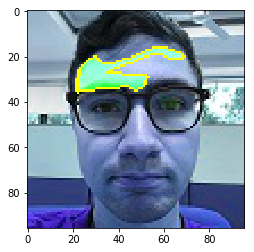

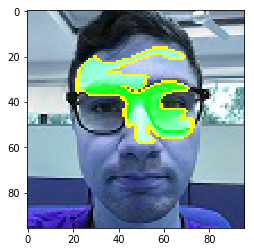

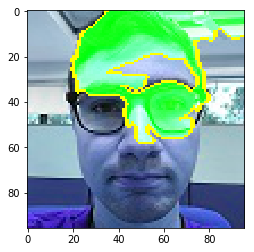

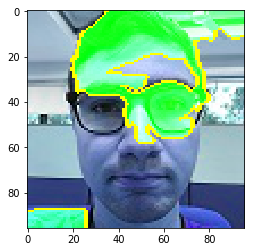

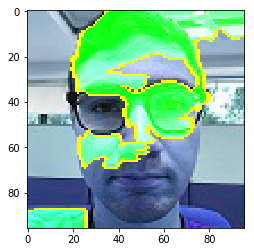

In [135]:
greg_exp = get_explanation("images/greg_positive.jpg")

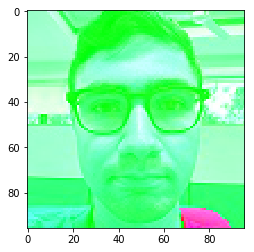

In [122]:
temp, mask = greg_exp.get_image_and_mask(0, positive_only=False, num_features=100, hide_rest=False)
plt.imshow(temp)

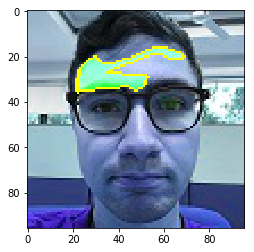

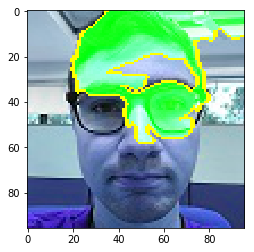

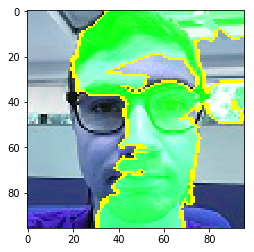

In [80]:
for i in [1, 3, 5]:
    temp, mask = greg_exp.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))

In [77]:
# top 1 feat
total = 0
for idx, exp in greg_exp.local_exp[1][0:1]:
    total += exp

print(int(-100*total))

11


In [78]:
# top 3 feats
total = 0
for idx, exp in greg_exp.local_exp[1][0:3]:
    total += exp

print(int(-100*total))

32


In [79]:
# top 5 feats
total = 0
for idx, exp in greg_exp.local_exp[1][0:5]:
    total += exp

print(int(-100*total))

49


Imposter! Not Greg.


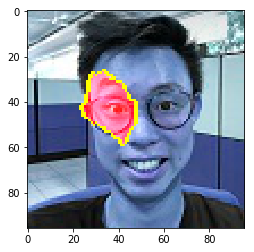

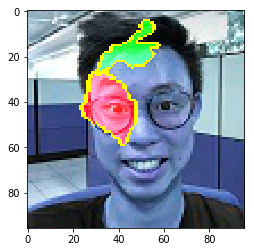

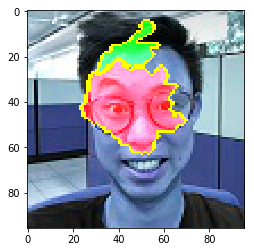

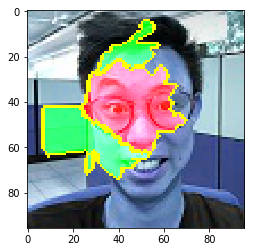

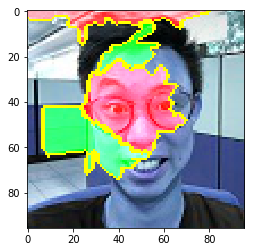

In [127]:
max_exp = get_explanation("images/maxim_positive.jpg")

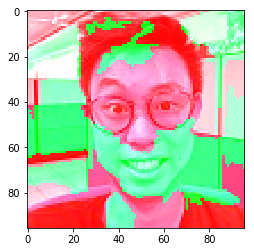

In [128]:
temp, mask = max_exp.get_image_and_mask(0, positive_only=False, num_features=100, hide_rest=False)
plt.imshow(temp)

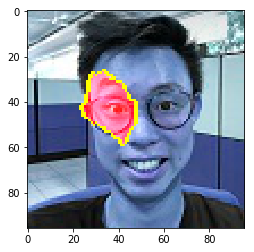

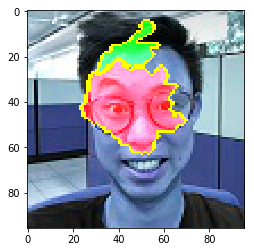

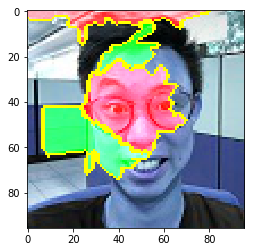

In [129]:
for i in [1, 3, 5]:
    temp, mask = max_exp.get_image_and_mask(0, positive_only=False, num_features=i, hide_rest=False)
    plt.figure()
    plt.imshow(mark_boundaries(temp, mask))

In [130]:
# top 1 feat
total = 0
for idx, exp in max_exp.local_exp[1][0:1]:
    total += abs(exp)

print(int(100*total))

5


In [131]:
# top 3 feats
total = 0
for idx, exp in max_exp.local_exp[1][0:3]:
    total += abs(exp)

print(int(100*total))

13


In [132]:
# top 5 feats
total = 0
for idx, exp in max_exp.local_exp[1][0:5]:
    total += abs(exp)

print(int(100*total))

20
